In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pinecone.grpc import PineconeGRPC as Pinecone
from config import pinecone_key
from config import openai_key
from sentence_transformers import SentenceTransformer
from deep_translator import GoogleTranslator
import torch
import datamapplot

In [3]:
# Set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

# set the deterministic flag
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Determine the device

device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device

0

In [6]:
# Get the data from pinecone
pc = Pinecone(api_key=pinecone_key)

# define the index
index_name = "loreal-sentiments-ke"

# Connect to the index
index = pc.Index(index_name)

# define the query
query = "Get all reviews for Dark spot corrector" 

# Define the query embedding model
query_embd_model = SentenceTransformer("all-MiniLM-L6-v2")

#embed the query
xq = query_embd_model.encode(query).tolist()

# get the results
results = index.query(xq, top_k=1000, include_metadata=True, filter={"$and": [{"product": {"$eq": "Garnier Even & Matte Dark Spot Corrector"}},{"sentiment_label": {"$eq": "negative"}}]})

In [7]:
results["matches"][:5]

[{'id': '4012',
  'metadata': {'average_rating': 4.0,
               'brand': 'Garnier',
               'date': '05-09-2022',
               'number_reviews': 562.0,
               'price': 542.0,
               'product': 'Garnier Even & Matte Dark Spot Corrector',
               'review': "Dark spot corrector.It didn't work for me",
               'sentiment_label': 'negative',
               'sentiment_score': 0.8002731204032898,
               'timestamp': 1652043600.0},
  'score': 0.7512471,
  'sparse_values': {'indices': [], 'values': []},
  'values': []},
 {'id': '4300',
  'metadata': {'average_rating': 4.0,
               'brand': 'Garnier',
               'date': '18-11-2021',
               'number_reviews': 562.0,
               'price': 542.0,
               'product': 'Garnier Even & Matte Dark Spot Corrector',
               'review': "garnier even & matte dark spot corrector.It didn't "
                         'remove the dark spots after using it for almost 2 '
       

In [8]:
# Define function to get all reviews sentimets & date
def get_metadata(results):

    reviews = [r["metadata"]["review"]for r in results["matches"]]
    dates = [r["metadata"]["date"] for r in results["matches"]]
    sentiments = [r["metadata"]["sentiment_label"] for r in results["matches"]]

    return reviews, dates, sentiments

In [9]:
# get reviews 
reviews = get_metadata(results)[0]
reviews

["Dark spot corrector.It didn't work for me",
 "garnier even & matte dark spot corrector.It didn't remove the dark spots after using it for almost 2 month now.",
 "Dark spot corrector..Review after 24days of use. What's up with the quantity¿?? Why not just use a small tube then? If products quantity is little, using a big package just makes things worse. *It does nothing out of the ordinary that that the vitamin C brightening serum can't do. Yes,it is a good product but not a need for a skin care routine.",
 "doesnt work on the dark spots.Improve everything about the product or abolish it, it didn't work on me, not worth the money",
 'Overrated.Used a whole tube and my dark spots still stayed',
 "Overrated and expensive for nothing.It's simply overrated. Makes my face extra shiny and oily. I still have the dark spots even after using daily for over a month",
 'I feel confused about it.Not sure it will help remove dark spots ????????',
 'Mixed feelings.I haven’t finished a tube yet, but

In [16]:
#Topic Modelling

In [42]:
import openai
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from transformers import AutoTokenizer

# Select the model
model_id = "BAAI/bge-small-en-v1.5"

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, do_lower_case=True)

#Define the embedding 
embed_model = SentenceTransformer(model_id, tokenizer, device=device)
embeddings = embed_model.encode(reviews, show_progress_bar=True)

# Define submodel
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric="cosine", random_state=42) # Dimesionality reduction
hdbscan_model = HDBSCAN(min_cluster_size=25, metric="euclidean", cluster_selection_method="eom", prediction_data=True) # Clustering

# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)

# reduce embedding
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
# representation
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech, OpenAI

#Keybert
keybert_model = KeyBERTInspired()

# Part of speech
pos_model = PartOfSpeech("en_core_web_lg")

#mmr
mmr_model = MaximalMarginalRelevance(diversity=0.3)

#Create prompt
prompt = """
You are an expert in natural language processing and topic modeling. Below is a topic extracted from a collection of documents:

- Documents: [DOCUMENTS]

The topic is described by the following keywords:

- Keywords: [KEYWORDS]

Your task is to generate a concise and highly descriptive topic label that accurately captures the essence of the documents. The label should be insightful, informative, and no more than 5 words long.

Please format the output as:
topic: <topic label>
"""

client = openai.OpenAI(api_key=openai_key)
openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, prompt=prompt,chat=True)

#all representation model
representation_model = {
    "KeyBert": keybert_model,
    "OpenAI": openai_model,
    "POS": pos_model,
    "MMR": mmr_model
}

In [57]:
# Initialize bert model
from bertopic import BERTopic

topic_model = BERTopic(

    #pipeline model
    embedding_model=embed_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model, 
    representation_model=representation_model,

    #Hyperparameter
    top_n_words=10, 
    verbose=True, 
    calculate_probabilities=True,
    n_gram_range=(1,3)
)

topics, probs = topic_model.fit_transform(reviews, embeddings)

2024-08-08 16:58:56,470 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-08 16:58:58,249 - BERTopic - Dimensionality - Completed ✓
2024-08-08 16:58:58,252 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-08 16:58:58,296 - BERTopic - Cluster - Completed ✓
2024-08-08 16:58:58,317 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]
2024-08-08 16:59:04,993 - BERTopic - Representation - Completed ✓


In [58]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBert,OpenAI,POS,MMR,Representative_Docs
0,-1,18,-1_work_didn_didn work_work expected,"[work, didn, didn work, work expected, doesn w...","[didn work, doesn work, works, didn, worked, d...",[Dissatisfaction with Product Effectiveness],"[good, worth, expensive, results, week, face, ...","[work, didn work, work expected, hate, doesn, ...","[Didn't work.Didn't work, nope.Didn't work for..."
1,0,64,0_face_dark_didn_work,"[face, dark, didn, work, don, week, like, don ...","[dark spot, spot corrector, dark, doesn work, ...",[Dark spot corrector effectiveness],"[dark, face, week, product, small, corrector, ...","[face, dark, don like, didn work, garnier, spo...",[Dark spot corrector..Review after 24days of u...
2,1,63,1_product_tube_little_air,"[product, tube, little, air, used, like, quant...","[small quantity, quantity tube, quantity littl...",[Product Quantity Dissatisfaction],"[product, tube, little, air, quantity, good, p...","[tube, little, used, like, quantity, products,...","[Not bad.Amount paid vs quantity are a scam,th..."


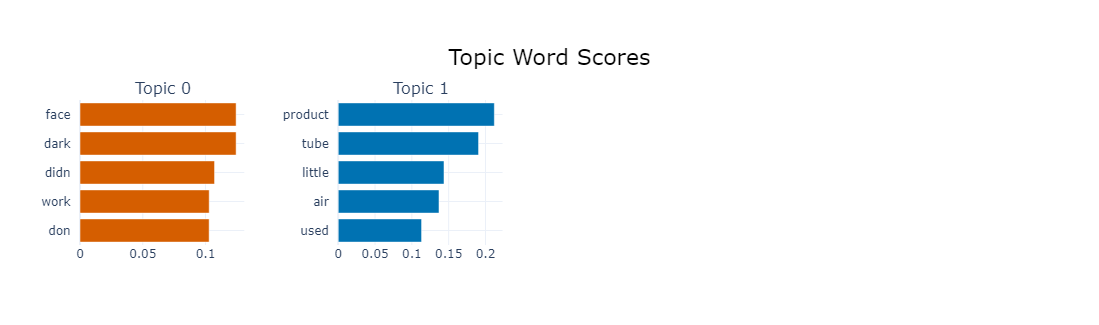

In [59]:
topic_model.visualize_barchart()

In [47]:
# Reduce outliers using the `distributions` strategy
#new_topics = topic_model.reduce_outliers(reviews, topics, strategy="distributions")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 131.58it/s]


In [48]:
#topic_model.update_topics(reviews, topics=new_topics)

2024-08-08 13:28:16,900 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [49]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBert,OpenAI,POS,MMR,Representative_Docs
0,0,79,0_it_the_not_work,"[it, the, not, work, for, my, didn, me, and, f...","[dark spot, spot corrector, dark, doesn work, ...","[""Ineffective dark spot corrector""]","[dark, face, week, product, small, corrector, ...","[face, dark, don like, didn work, garnier, spo...",[Dark spot corrector..Review after 24days of u...
1,1,66,1_the_is_it_product,"[the, is, it, product, empty, tube, was, not, ...","[small quantity, quantity tube, quantity littl...",[Disappointment with product quantity],"[product, tube, little, air, quantity, good, p...","[tube, little, used, like, quantity, products,...","[Not bad.Amount paid vs quantity are a scam,th..."


In [61]:
# or ChatGPT's labels
gpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
#chatgpt_topic_labels[-1] = "Others"
topic_model.set_topic_labels(gpt_topic_labels)

In [62]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBert,OpenAI,POS,MMR,Representative_Docs
0,-1,18,-1_work_didn_didn work_work expected,Dissatisfaction with Product Effectiveness,"[work, didn, didn work, work expected, doesn w...","[didn work, doesn work, works, didn, worked, d...",[Dissatisfaction with Product Effectiveness],"[good, worth, expensive, results, week, face, ...","[work, didn work, work expected, hate, doesn, ...","[Didn't work.Didn't work, nope.Didn't work for..."
1,0,64,0_face_dark_didn_work,Dark spot corrector effectiveness,"[face, dark, didn, work, don, week, like, don ...","[dark spot, spot corrector, dark, doesn work, ...",[Dark spot corrector effectiveness],"[dark, face, week, product, small, corrector, ...","[face, dark, don like, didn work, garnier, spo...",[Dark spot corrector..Review after 24days of u...
2,1,63,1_product_tube_little_air,Product Quantity Dissatisfaction,"[product, tube, little, air, used, like, quant...","[small quantity, quantity tube, quantity littl...",[Product Quantity Dissatisfaction],"[product, tube, little, air, quantity, good, p...","[tube, little, used, like, quantity, products,...","[Not bad.Amount paid vs quantity are a scam,th..."


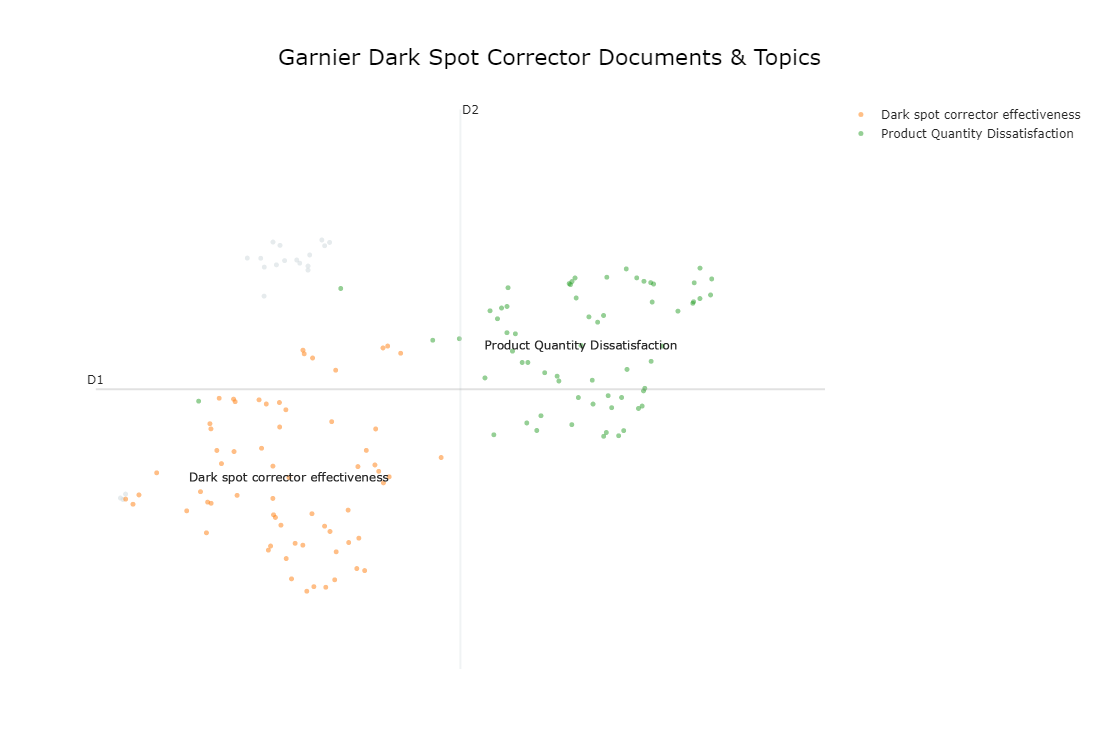

In [63]:
topic_model.visualize_documents(reviews, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=False, hide_annotations=False, custom_labels=gpt_topic_labels, title="Garnier Dark Spot Corrector Documents & Topics")

# Save the figure
#fig.write_image("Dark-spot-corrector_negative_reviews.png", scale=2)

#fig.show()

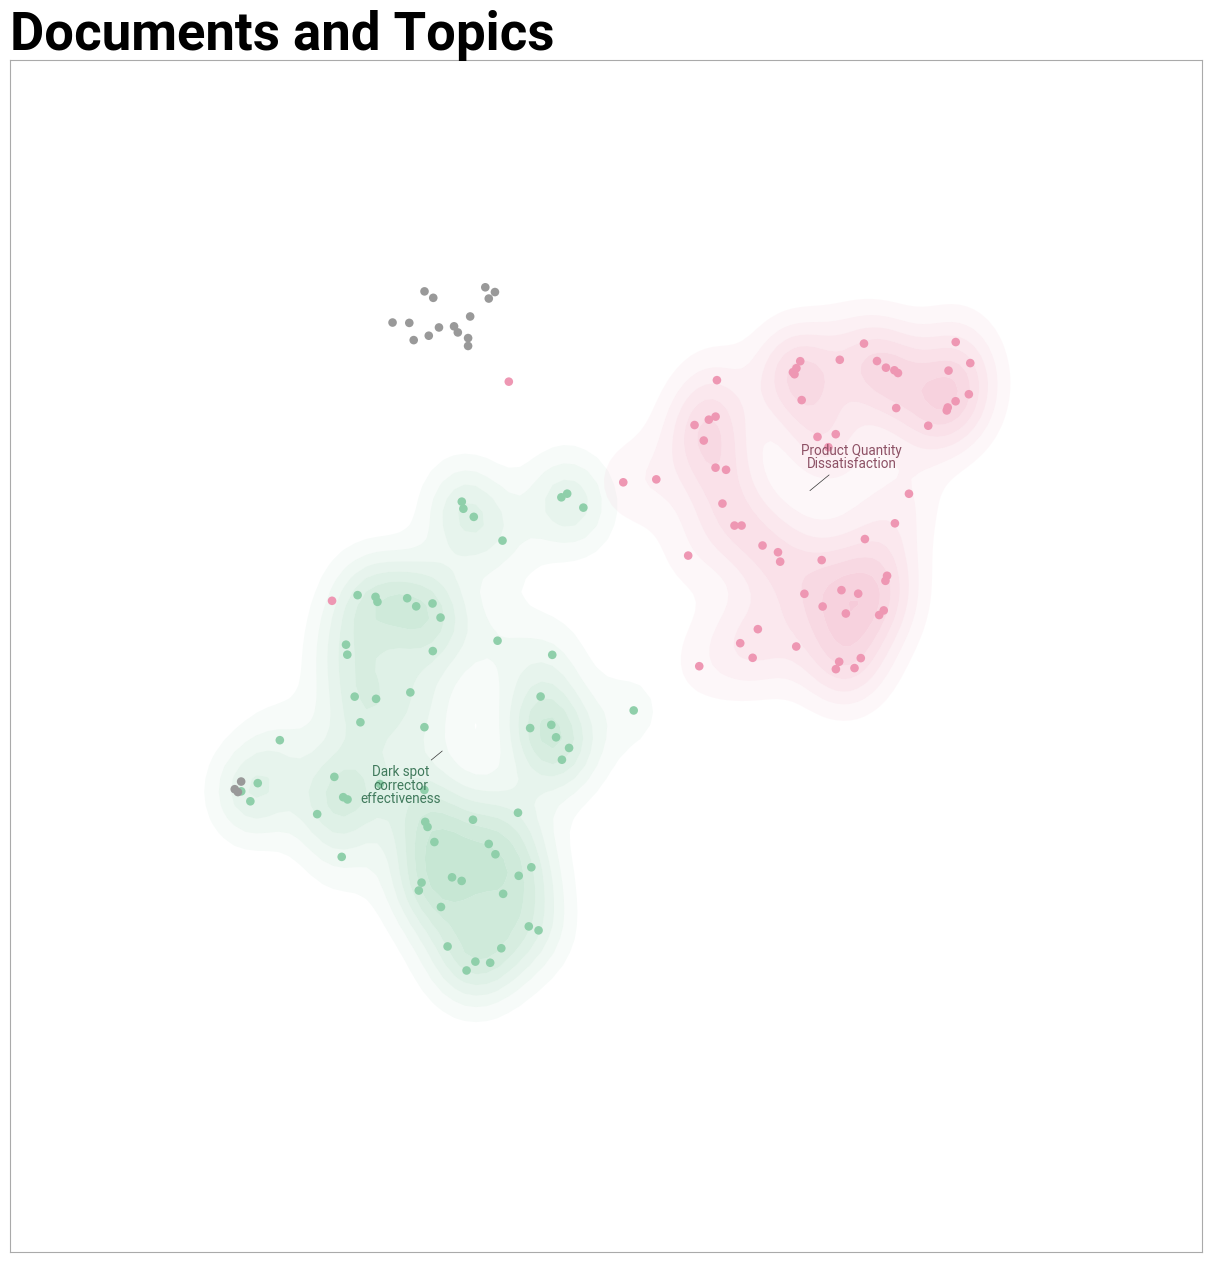

In [64]:
fig_2 = topic_model.visualize_document_datamap(docs=reviews, reduced_embeddings=reduced_embeddings, custom_labels=gpt_topic_labels)

fig_2.show()

In [65]:
tops = topic_model.get_topic_info()
data = tops[["Count", "CustomName"]]

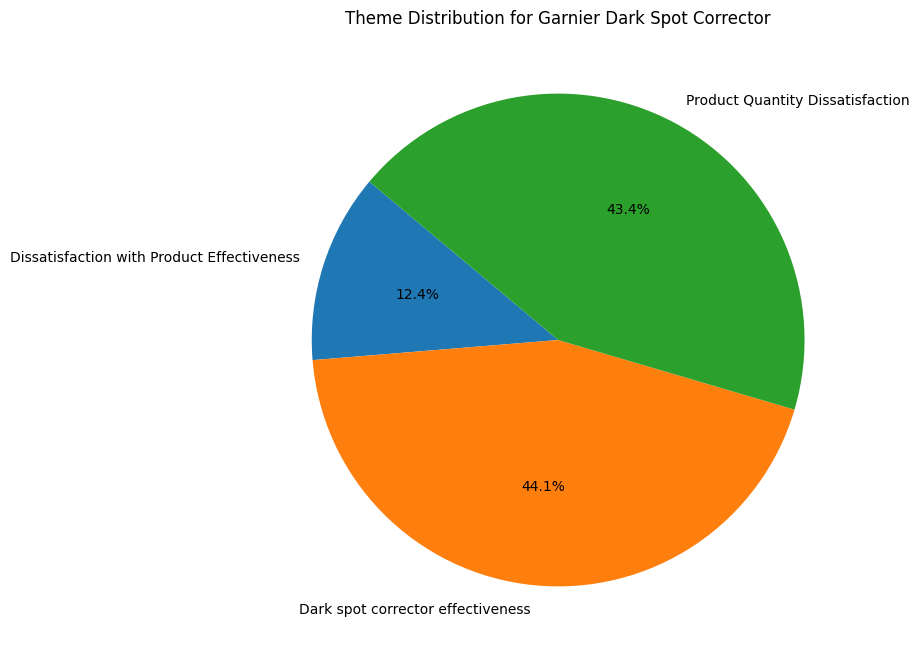

In [66]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 8))
plt.pie(data["Count"], labels=data["CustomName"], autopct='%1.1f%%', startangle=140)

plt.title("Theme Distribution for Garnier Dark Spot Corrector")


plt.show()
